# Model 1: Logistic Regression Baseline
## Testing across all preprocessing strategies

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, recall_score,
    precision_recall_curve, roc_curve, classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

## 1. Load Preprocessed Data from All Strategies

In [2]:
# Dictionary to store results
results = {}

# List all preprocessing strategies
strategies = [
    'strategy1',  # Simple imputation
    'strategy2a_knn',  # KNN imputation
    'strategy2b_mice',  # MICE imputation
    'strategy3_domain'  # Domain-informed
]

strategy_names = {
    'strategy1': 'Simple (Median/Mode)',
    'strategy2a_knn': 'KNN Imputation',
    'strategy2b_mice': 'MICE Imputation',
    'strategy3_domain': 'Domain-Informed'
}

print("Loading preprocessed datasets...")

Loading preprocessed datasets...


## 2. Train Logistic Regression on Each Strategy

In [3]:
models = {}
predictions = {}

for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Training Logistic Regression - {strategy_names[strategy]}")
    print(f"{'='*70}")
    
    # Load data
    X_train = pd.read_csv(f'preprocessed_data/{strategy}_X_train.csv')
    X_test = pd.read_csv(f'preprocessed_data/{strategy}_X_test.csv')
    
    # Load targets (same filename pattern for strategies 1 and 3, different for 2)
    if 'strategy2' in strategy:
        y_train = pd.read_csv('preprocessed_data/strategy2_y_train.csv')['undetectable']
        y_test = pd.read_csv('preprocessed_data/strategy2_y_test.csv')['undetectable']
    else:
        y_train = pd.read_csv(f'preprocessed_data/{strategy}_y_train.csv')['undetectable']
        y_test = pd.read_csv(f'preprocessed_data/{strategy}_y_test.csv')['undetectable']
    
    print(f"Training shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
    
    # Train Logistic Regression
    # Use L2 regularization (default), class_weight='balanced' to handle imbalance
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        solver='lbfgs'
    )
    
    lr_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    y_pred = lr_model.predict(X_test)
    
    # Store results
    models[strategy] = lr_model
    predictions[strategy] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Model trained successfully!")

print(f"\nAll models trained!")


Training Logistic Regression - Simple (Median/Mode)
Training shape: (26408, 32)
Test shape: (6603, 32)
Model trained successfully!

Training Logistic Regression - KNN Imputation
Training shape: (26408, 32)
Test shape: (6603, 32)
Model trained successfully!

Training Logistic Regression - MICE Imputation


Training shape: (26408, 32)
Test shape: (6603, 32)
Model trained successfully!

Training Logistic Regression - Domain-Informed
Training shape: (26408, 43)
Test shape: (6603, 43)
Model trained successfully!

All models trained!


## 3. Evaluate Models - AUROC, PR AUC, Recall

In [4]:
evaluation_results = []

for strategy in strategies:
    y_test = predictions[strategy]['y_test']
    y_pred = predictions[strategy]['y_pred']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    
    # Calculate recall at specific thresholds
    thresholds = [0.3, 0.5, 0.7]
    recalls_at_thresholds = {}
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        recalls_at_thresholds[thresh] = recall_score(y_test, y_pred_thresh)
    
    evaluation_results.append({
        'Strategy': strategy_names[strategy],
        'AUROC': auroc,
        'PR AUC': pr_auc,
        'Recall (default)': recall,
        'Recall @0.3': recalls_at_thresholds[0.3],
        'Recall @0.5': recalls_at_thresholds[0.5],
        'Recall @0.7': recalls_at_thresholds[0.7]
    })

# Create results DataFrame
results_df = pd.DataFrame(evaluation_results)
print("\n" + "="*90)
print("LOGISTIC REGRESSION - EVALUATION RESULTS")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)


LOGISTIC REGRESSION - EVALUATION RESULTS
            Strategy    AUROC   PR AUC  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
Simple (Median/Mode) 0.970370 0.888359          0.997289     1.000000     0.997289     0.949842
      KNN Imputation 0.965537 0.867804          0.992770     0.999548     0.992770     0.944871
     MICE Imputation 0.967849 0.869962          0.994577     0.999548     0.994577     0.947131
     Domain-Informed 0.978857 0.936482          0.994126     1.000000     0.994126     0.964754


## 4. Detailed Classification Reports

In [5]:
for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Classification Report - {strategy_names[strategy]}")
    print(f"{'='*70}")
    
    y_test = predictions[strategy]['y_test']
    y_pred = predictions[strategy]['y_pred']
    
    print(classification_report(y_test, y_pred, 
                                target_names=['Not Suppressed', 'Suppressed']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"  [TN={cm[0,0]}, FP={cm[0,1]}]")
    print(f"  [FN={cm[1,0]}, TP={cm[1,1]}]")


Classification Report - Simple (Median/Mode)
                precision    recall  f1-score   support

Not Suppressed       1.00      0.91      0.95      4390
    Suppressed       0.85      1.00      0.92      2213

      accuracy                           0.94      6603
     macro avg       0.92      0.95      0.93      6603
  weighted avg       0.95      0.94      0.94      6603




Confusion Matrix:
[[3988  402]
 [   6 2207]]
  [TN=3988, FP=402]
  [FN=6, TP=2207]

Classification Report - KNN Imputation
                precision    recall  f1-score   support

Not Suppressed       1.00      0.90      0.95      4390
    Suppressed       0.83      0.99      0.91      2213

      accuracy                           0.93      6603
     macro avg       0.91      0.95      0.93      6603
  weighted avg       0.94      0.93      0.93      6603


Confusion Matrix:
[[3952  438]
 [  16 2197]]
  [TN=3952, FP=438]
  [FN=16, TP=2197]

Classification Report - MICE Imputation
                precision    recall  f1-score   support

Not Suppressed       1.00      0.90      0.95      4390
    Suppressed       0.84      0.99      0.91      2213

      accuracy                           0.93      6603
     macro avg       0.92      0.95      0.93      6603
  weighted avg       0.94      0.93      0.94      6603


Confusion Matrix:
[[3965  425]
 [  12 2201]]
  [TN=3965, FP=425]
  [FN=

## 5. Visualization - ROC Curves

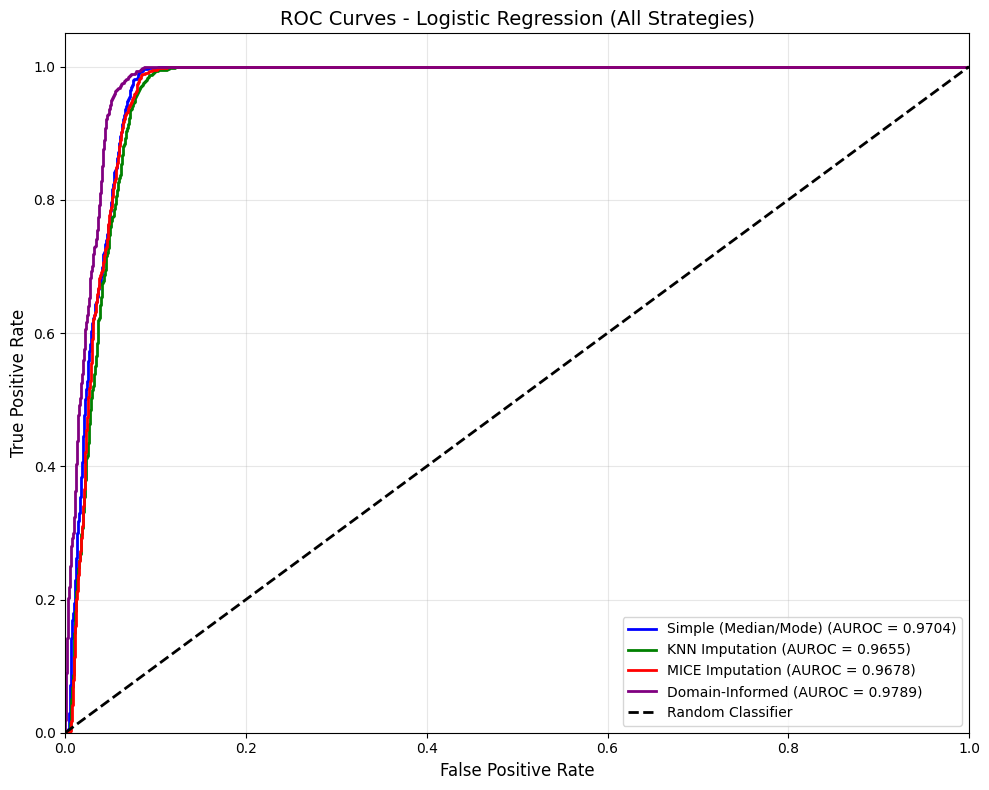

In [6]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']

for idx, strategy in enumerate(strategies):
    y_test = predictions[strategy]['y_test']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{strategy_names[strategy]} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression (All Strategies)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_regression_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Visualization - Precision-Recall Curves

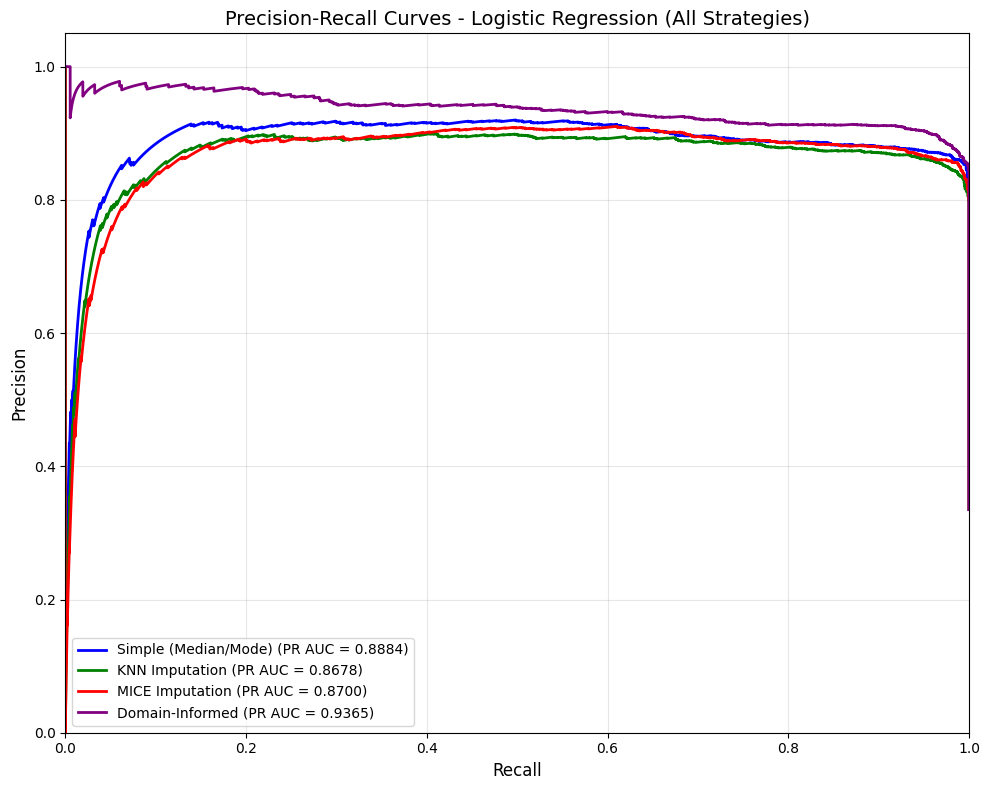

In [7]:
plt.figure(figsize=(10, 8))

for idx, strategy in enumerate(strategies):
    y_test = predictions[strategy]['y_test']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, color=colors[idx], lw=2,
             label=f'{strategy_names[strategy]} (PR AUC = {pr_auc:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Logistic Regression (All Strategies)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_regression_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Feature Importance (for best performing strategy)

Best performing strategy: Domain-Informed

Top 20 Most Important Features (by absolute coefficient):
                  Feature  Coefficient
10                  logvl   -16.742956
32         vload_category     3.093297
0                   visit    -1.446319
36          vload_missing    -1.345384
19                 APOBEC     0.686240
41       prev_suppression     0.622579
39       hemoglob_missing     0.473335
20                   APOB    -0.321934
21                 APOBgr    -0.321934
40       on_any_treatment    -0.220121
4                    nrti     0.209508
3                ageatvis    -0.200005
29    treatment_intensity     0.188036
30               on_haart     0.186514
9                genotype    -0.174771
5                   nnrti     0.152975
16                    vla     0.137183
38            cd8_missing    -0.133302
23                 Hgbgen     0.132719
31  cd4_cd8_ratio_missing     0.131902


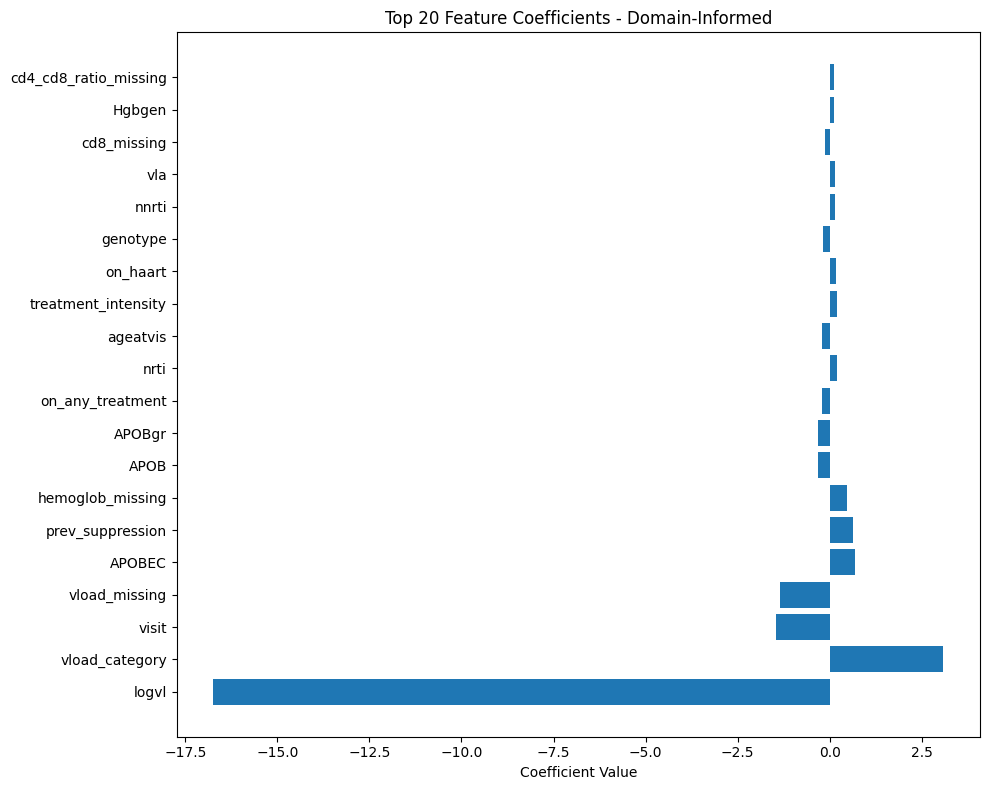

In [8]:
# Find best strategy based on AUROC
best_strategy_idx = results_df['AUROC'].idxmax()
best_strategy = strategies[best_strategy_idx]
best_strategy_name = strategy_names[best_strategy]

print(f"Best performing strategy: {best_strategy_name}")

# Get feature coefficients
model = models[best_strategy]
X_train = pd.read_csv(f'preprocessed_data/{best_strategy}_X_train.csv')
feature_names = X_train.columns

coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 20 Most Important Features (by absolute coefficient):")
print(coefficients.head(20))

# Visualize top features
plt.figure(figsize=(10, 8))
top_features = coefficients.head(20)
plt.barh(range(len(top_features)), top_features['Coefficient'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 20 Feature Coefficients - {best_strategy_name}')
plt.tight_layout()
plt.savefig('logistic_regression_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Results

In [9]:
import os
os.makedirs('model_results', exist_ok=True)

# Save evaluation results
results_df.to_csv('model_results/logistic_regression_results.csv', index=False)

# Save models
for strategy in strategies:
    with open(f'model_results/logistic_regression_{strategy}.pkl', 'wb') as f:
        pickle.dump(models[strategy], f)

# Save predictions
with open('model_results/logistic_regression_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

print("Results saved to 'model_results/' directory")

Results saved to 'model_results/' directory


## 9. Summary

In [10]:
print("\n" + "="*90)
print("LOGISTIC REGRESSION - SUMMARY")
print("="*90)

print("\nModel Configuration:")
print("  - Algorithm: Logistic Regression with L2 regularization")
print("  - Class weights: Balanced (to handle class imbalance)")
print("  - Solver: LBFGS")
print("  - Max iterations: 1000")

print("\nPreprocessing Strategies Tested:")
for strategy in strategies:
    print(f"  - {strategy_names[strategy]}")

print("\nBest Strategy:")
print(f"  - {best_strategy_name}")
print(f"  - AUROC: {results_df.loc[best_strategy_idx, 'AUROC']:.4f}")
print(f"  - PR AUC: {results_df.loc[best_strategy_idx, 'PR AUC']:.4f}")
print(f"  - Recall: {results_df.loc[best_strategy_idx, 'Recall (default)']:.4f}")

print("\nKey Findings:")
auroc_range = results_df['AUROC'].max() - results_df['AUROC'].min()
print(f"  - AUROC range across strategies: {auroc_range:.4f}")
print(f"  - Average AUROC: {results_df['AUROC'].mean():.4f}")
print(f"  - Average PR AUC: {results_df['PR AUC'].mean():.4f}")

print("\n" + "="*90)


LOGISTIC REGRESSION - SUMMARY

Model Configuration:
  - Algorithm: Logistic Regression with L2 regularization
  - Class weights: Balanced (to handle class imbalance)
  - Solver: LBFGS
  - Max iterations: 1000

Preprocessing Strategies Tested:
  - Simple (Median/Mode)
  - KNN Imputation
  - MICE Imputation
  - Domain-Informed

Best Strategy:
  - Domain-Informed
  - AUROC: 0.9789
  - PR AUC: 0.9365
  - Recall: 0.9941

Key Findings:
  - AUROC range across strategies: 0.0133
  - Average AUROC: 0.9707
  - Average PR AUC: 0.8907

